### Vigenere cipher. Frequency cryptanalysis. (Ukrainian language).
#### Author: Vadym Tunik.

In [16]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

The cipher is based on the Ukrainian alphabet. Two Ukrainian classical literary texts were used as examples of the cipher's use.

In [17]:
file_path = "text.txt"
with open(file_path, mode='r', encoding="utf-8") as file:
    file_lines = file.readlines()

file_lines[:3]

['Хіба ревуть воли, як ясла повні?\n', 'Панас Мирний\n', 'ЧАСТИНА ПЕРША\n']

In [18]:
letters=['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х','ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']

In [19]:
def clean_string(text:str) -> str:
    """
    The function removes all characters, spaces, and numbers from the text and makes all letters lowercase.
    """
    cleaned_text = re.sub(r'[\s\d\W]', '', text.lower())
    global letters
    cleaned_text = ''.join(char for char in cleaned_text if char in letters)
    return cleaned_text

In [20]:
#we will process the text for further work
clean_text = ''
for line in file_lines:
    clean_text += clean_string(line.rstrip())
clean_text[:50]

'хібаревутьволиякяслаповніпанасмирнийчастинапершапо'

### Create a histogram of the frequency of letters in the text.

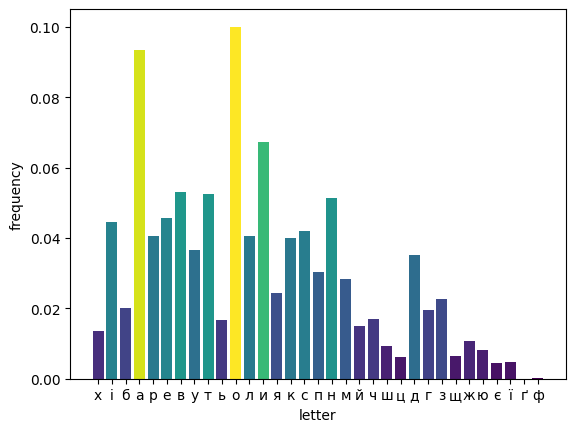

In [21]:
counts = Counter(clean_text)
letters = list(counts.keys())
frequencies = np.array(list(counts.values()))
text_len = len(clean_text)
frequencies = frequencies/text_len #calculate the percentage of the letter in the text

my_cmap = plt.get_cmap("viridis")
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
plt.bar(letters, frequencies, color=my_cmap(rescale(frequencies)))
plt.xlabel('letter')
plt.ylabel('frequency')
plt.show()

### Implement the Vigenere encryption algorithm.

In [22]:
def encrypt_text(text_origin:str, key='візерунок') -> str:
    """
    The function implements Vigenere encryption and returns the encrypted text.
    text_origin: plaintext without spaces, numbers, or symbols.
    key: the key word of the cipher.
    """
    assert 5 <= len(key) <= 20 , "The key length is incorrect. The minimum key length is 5, the maximum is 20."
    letters=['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х','ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
    key_multiplier = (len(text_origin)//len(key)) + 1
    text_key = key * key_multiplier

    text_encrypted = ''
    for i in range(len(text_origin)):
        letter_origin = text_origin[i]
        letter_key = text_key[i]
        index_sum = (letters.index(letter_origin) + letters.index(letter_key))%len(letters)

        text_encrypted += letters[index_sum]
    
    assert len(text_origin)==len(text_encrypted), "The length of the encrypted text does not match the length of the original text"
    return text_encrypted


with open('text2.txt', mode='r', encoding="utf-8") as file:
    file_lines = file.readlines()

#process the text2 for further work
clean_text2 = ''
for line in file_lines:
    clean_text2 += clean_string(line.rstrip())
print(f'{clean_text2[:50]=}')

encrypted_text = encrypt_text(clean_text2, 'візерунок')
print(f'{encrypted_text[:50]=}')


clean_text2[:50]='тарасбульбамиколагогольтарасбульбапереклавмиколаса'
encrypted_text[:50]='фіщежфєаігіхмбжяонркчснїндкуїяснфнґртнусрхашшрцзчр'


### Perform a cryptanalysis of the Wigener cipher and decrypt the proposed ciphertext without knowing the secret key.

In [23]:
def create_sequences(encrypted_text:str, key_length:int) -> list:
    """
    The function splits the ciphertext into an array of "periodic" subtexts
    encrypted_text: ciphertext
    key_length: key length, i.e. period
    """
    sequences_list = []
    encrypt_text_len = len(encrypted_text)
    for i in range(key_length):
        sequence = ''
        while i<encrypt_text_len:
            sequence += encrypted_text[i]
            i += key_length
        sequences_list.append(sequence)
    return sequences_list

sequences = create_sequences(encrypted_text=encrypted_text, key_length=5)
sequences[0][:50]

'ффіячдсррршхтжофгцсушузяеієшимьчжїлгтешвщохндршюгц'

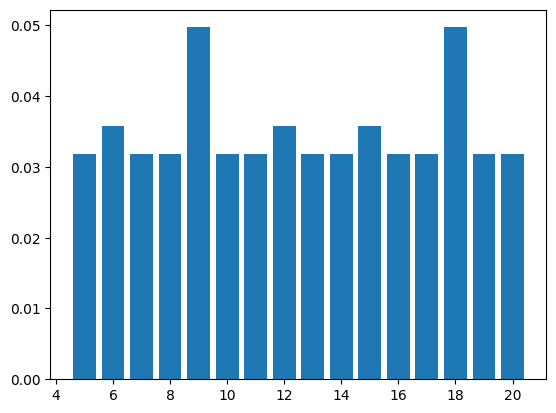

In [24]:
def calculate_IC(encrypted_text:str) -> float:
    """
    The function calculates the Index Coincidences for a given string
    """
    global letters
    
    IC = 0.
    N = len(encrypted_text)
    denominator = N * (N-1)
    for letter in letters:
        n = encrypted_text.count(letter)
        numerator = n * (n-1)
        IC += numerator/denominator
    return IC


def calculate_IC_means(encrypted_text:str) -> list:
    """
    The function calculates the average Index Coincidences for the received subtexts for periods from 5 to 20 inclusive.
    """
    IC_means = []
    for key_length in range(5,21): 
        sequences = create_sequences(encrypted_text=encrypted_text, key_length=key_length)
        sequences_IC = []
        for sequence in sequences:
            IC = calculate_IC(sequence)
            sequences_IC.append(IC)
        sequences_IC_mean = sum(sequences_IC)/len(sequences_IC)
        IC_means.append(sequences_IC_mean)
    return IC_means

IC_means = calculate_IC_means(encrypted_text)
plt.bar(list(range(5,21)), IC_means)
plt.show()

So, from the histogram, we can conclude that the key length is 9.

In [25]:
IC_means = np.array(IC_means)
IC_means = np.round(IC_means, 3)
IC_max = max(IC_means)
key_length = 5+np.where(IC_means == IC_max)[0][0]
key_length

9

In [26]:
def calculate_Chi_squared(encrypted_text:str, frequencies:list) -> float:
    """
    The function calculates chi-square statistics for text
    encrypted_text: encrypted text
    frequencies: a list with the frequencies of occurrence of the corresponding letter of the alphabet
    """
    global letters
    
    encrypted_text_len = len(encrypted_text)
    chi_squared = 0.
    for i in range(len(letters)):
        letter = letters[i]
        C_i = encrypted_text.count(letter)
        E_i = encrypted_text_len * frequencies[i]
        chi_squared += (C_i - E_i)**2 / E_i

    return chi_squared
    
calculate_Chi_squared(encrypted_text, frequencies)

47465806.49461056

In [27]:
def decrypt_caesar(encrypted_text:str, shift:int) -> str:
    letters=['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х','ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
    decrypted_text = ''
    for letter in encrypted_text:
        index = (letters.index(letter) - shift)%len(letters)
        decrypted_text += letters[index]
    return decrypted_text

Next steps:
1. Create key_length = 9 "periodic" subtexts
2. For each subtext, create every possible Caesar cipher
3. Choose the Caesar cipher with the smallest chi-square for each subtext

In [28]:
def find_key(encrypted_text:str, key_length:int) -> str:
    """
    The function finds a key of a given length in a given ciphertext
    encrypted_text: ciphertext
    key_length: key length
    """
    cipher_sequences = create_sequences(encrypted_text=encrypted_text, key_length=key_length)
    letters=['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х','ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']

    key = ''
    for sequence in cipher_sequences:
        
        chi_sq_list = []
        for i in range(len(letters)):
            decrypted_sequence = decrypt_caesar(sequence, i)
            chi_sq = calculate_Chi_squared(decrypted_sequence, frequencies)
            chi_sq_list.append(chi_sq)

        key_letter_index = chi_sq_list.index(min(chi_sq_list))
        key_letter = letters[key_letter_index]
        key += key_letter

    return key

find_key(encrypted_text=encrypted_text, key_length=key_length)

'візерунок'

In [29]:
def break_cipher(encrypted_text:str) -> str:
    """
    The function cracks the Vigenere cipher without knowing the secret key.
    encrypted_text: encrypted text
    """
    letters=['а', 'б', 'в', 'г', 'ґ', 'д', 'е', 'є', 'ж', 'з', 'и', 'і', 'ї', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х','ц', 'ч', 'ш', 'щ', 'ь', 'ю', 'я']
    IC_means = calculate_IC_means(encrypted_text)
    IC_means = np.array(IC_means)
    IC_means = np.round(IC_means, 3)
    IC_max = max(IC_means)
    key_length = 5+np.where(IC_means == IC_max)[0][0]
    key = find_key(encrypted_text=encrypted_text, key_length=key_length)

    key_multiplier = (len(encrypted_text)//len(key)) + 1
    text_key = key * key_multiplier

    text_decrypted = ''
    for i in range(len(encrypted_text)):
        letter_origin = encrypted_text[i]
        letter_key = text_key[i]
        index_sum = (letters.index(letter_origin) + len(letters) - letters.index(letter_key))%len(letters)
        text_decrypted += letters[index_sum]

    return text_decrypted

break_cipher(encrypted_text)[:50]

'тарасбульбамиколагогольтарасбульбапереклавмиколаса'

So, as you can see, the decryption was successful.